# Data Merging and Preparation for Multi-Horizon LSTM
- Merge all datasets: crops, discharge, precipitation, hypoxia
- Create sequences for different forecast horizons

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [12]:
DATA_DIR = Path('data/processed')
OUTPUT_DIR = Path('data/modeling')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Years with complete data (excluding 2020, 2022 due to missing hypoxia)
USABLE_YEARS = [y for y in range(2001, 2025) if y not in [2020, 2022]]

# Forecast scenarios - (start_month, end_month) for each
FORECAST_SCENARIOS = {
    'early_warning': {
        'months': (1, 3),  # Jan-Mar
        'lead_time': '4-month',
        'description': 'Early warning forecast (March data available)'
    },
    'mid_season': {
        'months': (1, 5),  # Jan-May
        'lead_time': '2-month',
        'description': 'Mid-season forecast (May data available)'
    },
    'near_term': {
        'months': (1, 6),  # Jan-Jun
        'lead_time': '1-month',
        'description': 'Near-term forecast (June data available)'
    }
}

In [13]:
# Load hypoxia data (TARGET)
hypoxia_file = 'data/processed/hypoxia_aggregated_wide.csv'
hypoxia_df = pd.read_csv(hypoxia_file)

# Load crop data
crop_file = DATA_DIR / 'crop_acreage_state_level.csv'
crop_df = pd.read_csv(crop_file)

# Load discharge data
discharge_file = DATA_DIR / 'river_discharge_monthly.csv'
discharge_df = pd.read_csv(discharge_file)

# Load precipitation data
precip_file = DATA_DIR / 'precipitation_regional_monthly.csv'
precip_df = pd.read_csv(precip_file)

In [14]:
# Filter to usable years
hypoxia_df = hypoxia_df[hypoxia_df['year'].isin(USABLE_YEARS)].copy()

print(f"\nHypoxia data after filtering:")
print(f"  Years: {hypoxia_df['year'].min()}-{hypoxia_df['year'].max()}")
print(f"  Records: {len(hypoxia_df)}")
print(f"  Target zones: {[c for c in hypoxia_df.columns if 'percent_hypoxic' in c]}")

# Check for missing values in targets
print(f"\nMissing values in targets:")
for col in hypoxia_df.columns:
    if 'percent_hypoxic' in col:
        missing = hypoxia_df[col].isna().sum()
        print(f"  {col}: {missing}")


Hypoxia data after filtering:
  Years: 2001-2024
  Records: 22
  Target zones: ['Zone1_percent_hypoxic', 'Zone2_percent_hypoxic', 'Zone3_percent_hypoxic']

Missing values in targets:
  Zone1_percent_hypoxic: 1
  Zone2_percent_hypoxic: 0
  Zone3_percent_hypoxic: 2


In [15]:
# Convert discharge from wide to long format (year-month rows)
discharge_cols = [c for c in discharge_df.columns if c.startswith('discharge_') and c.endswith('_cfs')]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

discharge_long = []
for _, row in discharge_df.iterrows():
    year = row['year']
    for month_idx, month_name in enumerate(month_names, 1):
        col_name = f'discharge_{month_name}_cfs'
        if col_name in discharge_df.columns:
            discharge_long.append({
                'year': year,
                'month': month_idx,
                'discharge_cfs': row[col_name]
            })

discharge_monthly = pd.DataFrame(discharge_long)


# Merge discharge and precipitation by year-month
monthly_features = discharge_monthly.merge(
    precip_df,
    on=['year', 'month'],
    how='outer'
)

# Add crop data (crops are annual, so repeat for each month)
crop_features = [c for c in crop_df.columns if c.endswith(('_corn', '_soy'))]
crop_annual = crop_df[['year'] + crop_features].copy()

monthly_features = monthly_features.merge(
    crop_annual,
    on='year',
    how='left'
)

# Filter to usable years and only Jan-Jun (we don't need July-Dec)
monthly_features = monthly_features[
    (monthly_features['year'].isin(USABLE_YEARS)) &
    (monthly_features['month'] <= 6)
].copy()

In [16]:
# Get all feature columns (exclude year and month)
feature_cols = [c for c in monthly_features.columns if c not in ['year', 'month']]

# Categorize features
discharge_features = ['discharge_cfs']
precip_features = [c for c in feature_cols if 'precip' in c]
crop_features_list = [c for c in feature_cols if c.endswith(('_corn', '_soy'))]

print(f"\nFeature categories:")
print(f"  Discharge features: {len(discharge_features)}")
print(f"    → {discharge_features}")
print(f"  Precipitation features: {len(precip_features)}")
print(f"    → {precip_features}")
print(f"  Crop features: {len(crop_features_list)}")
print(f"    → First 5: {crop_features_list[:5]}")
print(f"    → Last 5: {crop_features_list[-5:]}")

total_features = len(feature_cols)
print(f"\n  TOTAL FEATURES PER TIMESTEP: {total_features}")


Feature categories:
  Discharge features: 1
    → ['discharge_cfs']
  Precipitation features: 3
    → ['Central_precip_inches', 'Lower_precip_inches', 'Upper_precip_inches']
  Crop features: 26
    → First 5: ['ARKANSAS_corn', 'ILLINOIS_corn', 'INDIANA_corn', 'IOWA_corn', 'KENTUCKY_corn']
    → Last 5: ['MISSOURI_soy', 'OHIO_soy', 'SOUTH DAKOTA_soy', 'TENNESSEE_soy', 'WISCONSIN_soy']

  TOTAL FEATURES PER TIMESTEP: 30


In [18]:
def create_sequences(monthly_data, hypoxia_data, scenario_name, start_month, end_month):
    """
    Create input sequences for a specific forecast scenario
    
    Parameters:
    - monthly_data: DataFrame with monthly features
    - hypoxia_data: DataFrame with annual hypoxia targets
    - scenario_name: Name of scenario (e.g., 'early_warning')
    - start_month: First month of sequence (1=Jan)
    - end_month: Last month of sequence (3=Mar, 5=May, 6=Jun)
    
    Returns:
    - sequences: List of dictionaries with year, X, y
    """
    
    sequences = []
    feature_cols_local = [c for c in monthly_data.columns if c not in ['year', 'month']]
    
    for year in USABLE_YEARS:
        # Get monthly data for this year (start_month through end_month)
        year_data = monthly_data[
            (monthly_data['year'] == year) & 
            (monthly_data['month'] >= start_month) &
            (monthly_data['month'] <= end_month)
        ].copy()
        
        # Get hypoxia target for this year
        hypoxia_row = hypoxia_data[hypoxia_data['year'] == year]
        
        # Check if we have complete data
        expected_months = end_month - start_month + 1
        if len(year_data) == expected_months and len(hypoxia_row) == 1:
            # Sort by month to ensure correct order
            year_data = year_data.sort_values('month')
            
            # Extract features (X) and target (y)
            X = year_data[feature_cols_local].values  # Shape: (n_months, n_features)
            
            # Get hypoxia targets (3 zones)
            y = hypoxia_row[[
                'Zone1_percent_hypoxic',
                'Zone2_percent_hypoxic', 
                'Zone3_percent_hypoxic'
            ]].values[0]  # Shape: (3,)
            
            sequences.append({
                'year': year,
                'scenario': scenario_name,
                'X': X,
                'y': y,
                'n_timesteps': X.shape[0],
                'n_features': X.shape[1]
            })
    
    return sequences

# Create sequences for each forecast scenario
all_sequences = []

print("\nForecast scenarios:")
for scenario_name, scenario_info in FORECAST_SCENARIOS.items():
    start_month, end_month = scenario_info['months']
    lead_time = scenario_info['lead_time']
    description = scenario_info['description']
    
    print(f"\n{scenario_name.upper().replace('_', ' ')}:")
    print(f"  {description}")
    print(f"  Data: Jan through month {end_month}")
    print(f"  Sequence length: {end_month - start_month + 1} months")
    print(f"  Lead time: {lead_time}")
    
    sequences = create_sequences(
        monthly_features, 
        hypoxia_df, 
        scenario_name, 
        start_month, 
        end_month
    )
    all_sequences.extend(sequences)
    
    print(f"  Created {len(sequences)} sequences")
    
    if len(sequences) > 0:
        print(f"  Sample shape: X={sequences[0]['X'].shape}, y={sequences[0]['y'].shape}")

# Expected: 22 years × 3 scenarios = 66 sequences
print(f"  Expected: {len(USABLE_YEARS)} years × {len(FORECAST_SCENARIOS)} scenarios = {len(USABLE_YEARS) * len(FORECAST_SCENARIOS)}")
print(f"  Actual: {len(all_sequences)}")

if len(all_sequences) != len(USABLE_YEARS) * len(FORECAST_SCENARIOS):
    print(f"\nWARNING: Expected {len(USABLE_YEARS) * len(FORECAST_SCENARIOS)} sequences but got {len(all_sequences)}")
    print("  This may indicate missing data for some year-month combinations")


Forecast scenarios:

EARLY WARNING:
  Early warning forecast (March data available)
  Data: Jan through month 3
  Sequence length: 3 months
  Lead time: 4-month
  Created 22 sequences
  Sample shape: X=(3, 30), y=(3,)

MID SEASON:
  Mid-season forecast (May data available)
  Data: Jan through month 5
  Sequence length: 5 months
  Lead time: 2-month
  Created 22 sequences
  Sample shape: X=(5, 30), y=(3,)

NEAR TERM:
  Near-term forecast (June data available)
  Data: Jan through month 6
  Sequence length: 6 months
  Lead time: 1-month
  Created 22 sequences
  Sample shape: X=(6, 30), y=(3,)
  Expected: 22 years × 3 scenarios = 66
  Actual: 66


In [19]:
# Define year splits
TRAIN_YEARS = [y for y in range(2001, 2018)]  # 2001-2017: 17 years
VAL_YEARS = [2018, 2019, 2021]                 # 3 years  
TEST_YEARS = [2023, 2024]                      # 2 years

print(f"\nYear splits:")
print(f"  Train: {TRAIN_YEARS[0]}-{TRAIN_YEARS[-1]} ({len(TRAIN_YEARS)} years)")
print(f"  Val: {VAL_YEARS} ({len(VAL_YEARS)} years)")
print(f"  Test: {TEST_YEARS} ({len(TEST_YEARS)} years)")

# Split sequences by year
train_sequences = [s for s in all_sequences if s['year'] in TRAIN_YEARS]
val_sequences = [s for s in all_sequences if s['year'] in VAL_YEARS]
test_sequences = [s for s in all_sequences if s['year'] in TEST_YEARS]

print(f"\nSequence counts:")
print(f"  Train: {len(train_sequences)} sequences ({len(TRAIN_YEARS)} years × {len(FORECAST_SCENARIOS)} scenarios)")
print(f"  Val: {len(val_sequences)} sequences ({len(VAL_YEARS)} years × {len(FORECAST_SCENARIOS)} scenarios)")
print(f"  Test: {len(test_sequences)} sequences ({len(TEST_YEARS)} years × {len(FORECAST_SCENARIOS)} scenarios)")


Year splits:
  Train: 2001-2017 (17 years)
  Val: [2018, 2019, 2021] (3 years)
  Test: [2023, 2024] (2 years)

Sequence counts:
  Train: 51 sequences (17 years × 3 scenarios)
  Val: 9 sequences (3 years × 3 scenarios)
  Test: 6 sequences (2 years × 3 scenarios)


In [20]:
def pad_sequences_to_max_length(sequences, max_length=6):
    """
    Pad sequences to maximum length (6 months for near_term scenario)
    Different scenarios have different lengths (3, 5, 6 months)
    Padding at the beginning with zeros
    """
    
    X_list = []
    y_list = []
    years_list = []
    scenarios_list = []
    
    for seq in sequences:
        X = seq['X']
        y = seq['y']
        n_timesteps = X.shape[0]
        n_features = X.shape[1]
        
        # Pad with zeros at the beginning if needed
        if n_timesteps < max_length:
            padding = np.zeros((max_length - n_timesteps, n_features))
            X_padded = np.vstack([padding, X])
        else:
            X_padded = X
        
        X_list.append(X_padded)
        y_list.append(y)
        years_list.append(seq['year'])
        scenarios_list.append(seq['scenario'])
    
    return np.array(X_list), np.array(y_list), years_list, scenarios_list

# Pad sequences (max length is 6 for near_term scenario)
print("\nPadding sequences to max length (6 months)...")
print("  early_warning (3 months) will have 3 zeros padding")
print("  mid_season (5 months) will have 1 zero padding")
print("  near_term (6 months) will have no padding")

X_train, y_train, train_years, train_scenarios = pad_sequences_to_max_length(train_sequences)
X_val, y_val, val_years, val_scenarios = pad_sequences_to_max_length(val_sequences)
X_test, y_test, test_years, test_scenarios = pad_sequences_to_max_length(test_sequences)

print(f"\nArray shapes:")
print(f"  X_train: {X_train.shape}  (samples, timesteps, features)")
print(f"  y_train: {y_train.shape}  (samples, target_zones)")
print(f"  X_val: {X_val.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_test: {y_test.shape}")



Padding sequences to max length (6 months)...
  early_warning (3 months) will have 3 zeros padding
  mid_season (5 months) will have 1 zero padding
  near_term (6 months) will have no padding

Array shapes:
  X_train: (51, 6, 30)  (samples, timesteps, features)
  y_train: (51, 3)  (samples, target_zones)
  X_val: (9, 6, 30)
  y_val: (9, 3)
  X_test: (6, 6, 30)
  y_test: (6, 3)


In [21]:
# Reshape to 2D for scaler: (samples * timesteps, features)
n_samples_train, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

scaler = StandardScaler()
scaler.fit(X_train_reshaped)

# Transform all sets
X_train_scaled = scaler.transform(X_train_reshaped).reshape(n_samples_train, n_timesteps, n_features)
X_val_scaled = scaler.transform(X_val.reshape(-1, n_features)).reshape(X_val.shape[0], n_timesteps, n_features)
X_test_scaled = scaler.transform(X_test.reshape(-1, n_features)).reshape(X_test.shape[0], n_timesteps, n_features)

print(f"  ✓ Features normalized using StandardScaler")
print(f"  Mean of training features (non-zero): {X_train_scaled[X_train_scaled != 0].mean():.6f}")
print(f"  Std of training features (non-zero): {X_train_scaled[X_train_scaled != 0].std():.6f}")

# Note: We do NOT scale the targets (hypoxia percentages are already 0-100)
print(f"\n  Target (hypoxia) not scaled - keeping as percentages (0-100)")
print(f"  Train target range: {y_train.min():.2f} - {y_train.max():.2f}")


# Save as numpy arrays
np.save(OUTPUT_DIR / 'X_train.npy', X_train_scaled)
np.save(OUTPUT_DIR / 'y_train.npy', y_train)
np.save(OUTPUT_DIR / 'X_val.npy', X_val_scaled)
np.save(OUTPUT_DIR / 'y_val.npy', y_val)
np.save(OUTPUT_DIR / 'X_test.npy', X_test_scaled)
np.save(OUTPUT_DIR / 'y_test.npy', y_test)

print(f"\nSaved numpy arrays to {OUTPUT_DIR}/")

# Save metadata
metadata = {
    'feature_names': feature_cols,
    'target_names': ['Zone1_percent_hypoxic', 'Zone2_percent_hypoxic', 'Zone3_percent_hypoxic'],
    'zone_descriptions': ['Louisiana zone', 'Texas zone', 'Mexico zone'],
    'train_years': train_years,
    'val_years': val_years,
    'test_years': test_years,
    'train_scenarios': train_scenarios,
    'val_scenarios': val_scenarios,
    'test_scenarios': test_scenarios,
    'n_features': n_features,
    'n_timesteps': n_timesteps,
    'n_targets': 3,
    'usable_years': USABLE_YEARS,
    'forecast_scenarios': FORECAST_SCENARIOS
}

import pickle
with open(OUTPUT_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

with open(OUTPUT_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print(f"✓ Saved metadata and scaler")


  ✓ Features normalized using StandardScaler
  Mean of training features (non-zero): 0.000000
  Std of training features (non-zero): 1.000000

  Target (hypoxia) not scaled - keeping as percentages (0-100)
  Train target range: nan - nan

Saved numpy arrays to data/modeling/
✓ Saved metadata and scaler


✓ Saved visualization: data_summary.png

DATA PREPARATION COMPLETE!

📊 Final Dataset Summary:
  Total usable years: 22
  Total sequences: 66
  Features per timestep: 30
  Max sequence length: 6 months
  Target zones: 3 (Louisiana, Texas, Mexico)

📁 Files saved to data/modeling/:
  ✓ X_train.npy, y_train.npy (51 samples)
  ✓ X_val.npy, y_val.npy (9 samples)
  ✓ X_test.npy, y_test.npy (6 samples)
  ✓ metadata.pkl
  ✓ scaler.pkl
  ✓ data_summary.png

🎯 Forecast Scenarios:
    → 4-month lead time
  mid_season: Mid-season forecast (May data available)
    → 2-month lead time
  near_term: Near-term forecast (June data available)
    → 1-month lead time

✅ Ready for model training!
  Next: Run the LSTM model training script



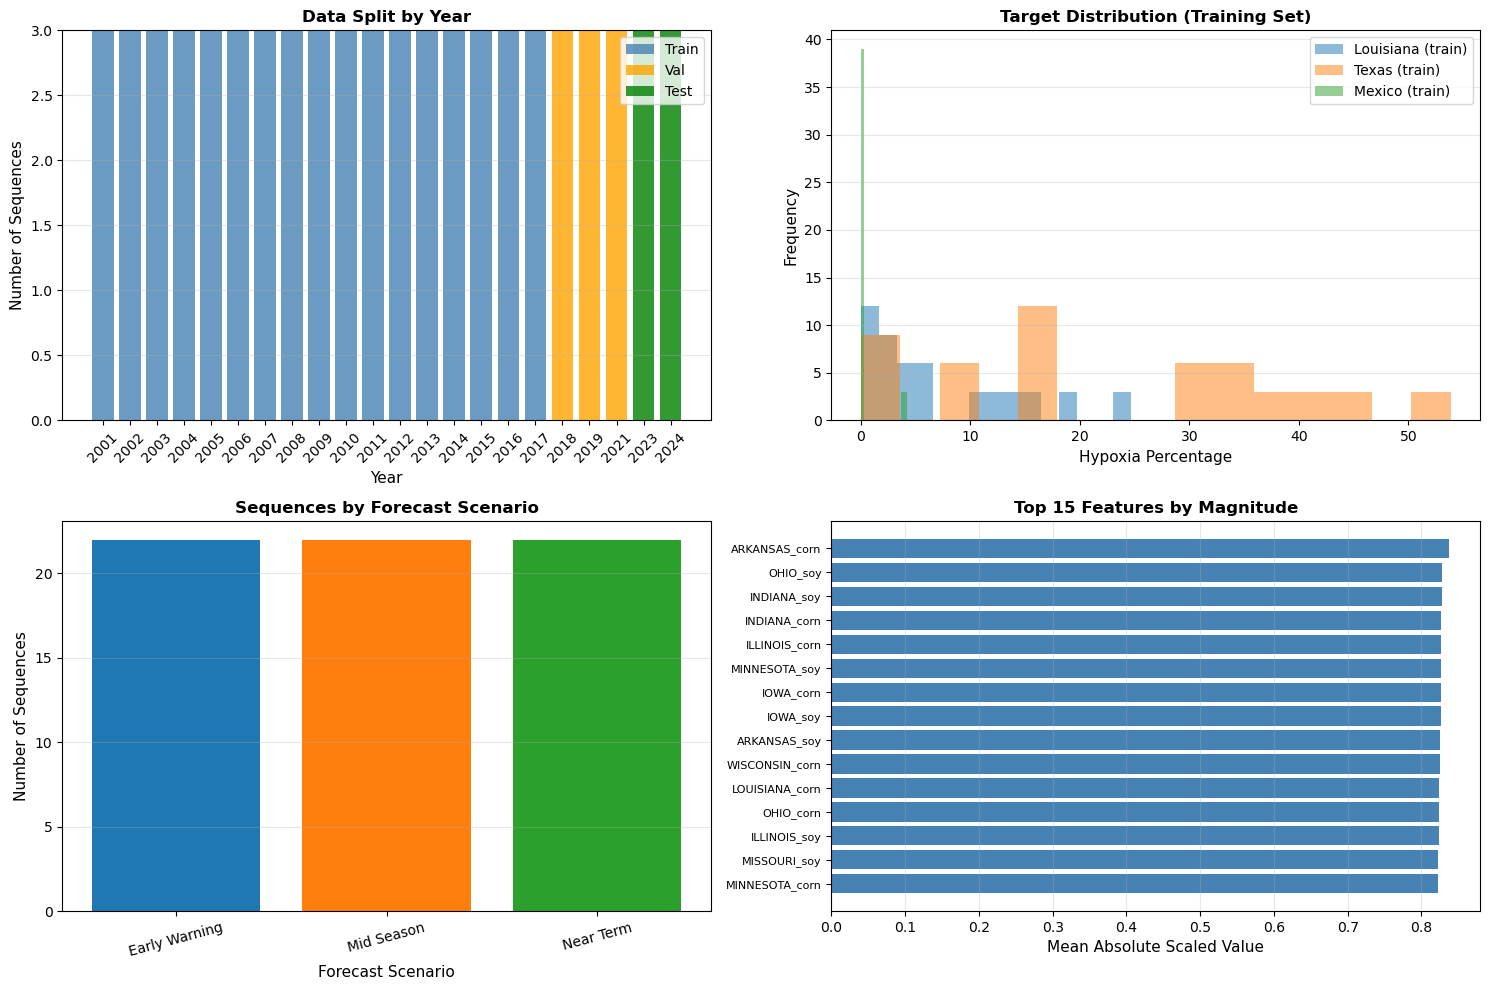

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sample distribution by year and split
ax1 = axes[0, 0]
year_labels = []
train_counts = []
val_counts = []
test_counts = []

for year in USABLE_YEARS:
    year_labels.append(year)
    train_counts.append(train_years.count(year))
    val_counts.append(val_years.count(year))
    test_counts.append(test_years.count(year))

x = np.arange(len(year_labels))
width = 0.8
ax1.bar(x, train_counts, width, label='Train', alpha=0.8, color='steelblue')
ax1.bar(x, val_counts, width, bottom=train_counts, label='Val', alpha=0.8, color='orange')
ax1.bar(x, test_counts, width, bottom=np.array(train_counts)+np.array(val_counts), 
        label='Test', alpha=0.8, color='green')
ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Number of Sequences', fontsize=11)
ax1.set_title('Data Split by Year', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(year_labels, rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: Target distribution (hypoxia percentages)
ax2 = axes[0, 1]
zone_names = ['Louisiana', 'Texas', 'Mexico']
for i, zone in enumerate(zone_names):
    ax2.hist(y_train[:, i], bins=15, alpha=0.5, label=f'{zone} (train)')
ax2.set_xlabel('Hypoxia Percentage', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Target Distribution (Training Set)', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Samples by forecast scenario
ax3 = axes[1, 0]
scenario_counts = {}
for scenario_name in FORECAST_SCENARIOS.keys():
    scenario_counts[scenario_name.replace('_', ' ').title()] = len([s for s in all_sequences if s['scenario'] == scenario_name])

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
ax3.bar(scenario_counts.keys(), scenario_counts.values(), color=colors)
ax3.set_xlabel('Forecast Scenario', fontsize=11)
ax3.set_ylabel('Number of Sequences', fontsize=11)
ax3.set_title('Sequences by Forecast Scenario', fontweight='bold')
ax3.set_xticklabels(scenario_counts.keys(), rotation=15)
ax3.grid(True, alpha=0.3, axis='y')

# Plot 4: Feature importance preview (mean absolute values in training set)
ax4 = axes[1, 1]
# Calculate mean absolute feature values across all timesteps (excluding padding zeros)
feature_means = np.abs(X_train_scaled[X_train_scaled != 0]).reshape(-1, n_features).mean(axis=0)
# Get top 15 features
top_15_idx = np.argsort(feature_means)[-15:]
top_15_names = [feature_cols[i][:25] for i in top_15_idx]  # Truncate names
top_15_values = feature_means[top_15_idx]

ax4.barh(range(len(top_15_names)), top_15_values, color='steelblue')
ax4.set_yticks(range(len(top_15_names)))
ax4.set_yticklabels(top_15_names, fontsize=8)
ax4.set_xlabel('Mean Absolute Scaled Value', fontsize=11)
ax4.set_title('Top 15 Features by Magnitude', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'data_summary.png', dpi=150, bbox_inches='tight')
print("✓ Saved visualization: data_summary.png")

# =============================================================================
# STEP 11: SUMMARY
# =============================================================================

print("\n" + "="*80)
print("DATA PREPARATION COMPLETE!")
print("="*80)

print(f"\n📊 Final Dataset Summary:")
print(f"  Total usable years: {len(USABLE_YEARS)}")
print(f"  Total sequences: {len(all_sequences)}")
print(f"  Features per timestep: {n_features}")
print(f"  Max sequence length: {n_timesteps} months")
print(f"  Target zones: 3 (Louisiana, Texas, Mexico)")

print(f"\n📁 Files saved to {OUTPUT_DIR}/:")
print(f"  ✓ X_train.npy, y_train.npy ({len(train_sequences)} samples)")
print(f"  ✓ X_val.npy, y_val.npy ({len(val_sequences)} samples)")
print(f"  ✓ X_test.npy, y_test.npy ({len(test_sequences)} samples)")
print(f"  ✓ metadata.pkl")
print(f"  ✓ scaler.pkl")
print(f"  ✓ data_summary.png")

print(f"\n🎯 Forecast Scenarios:")
for scenario_name, scenario_info in FORECAST_SCENARIOS.items():
    print(f"  {scenario_name}: {scenario_info['description']}")
    print(f"    → {scenario_info['lead_time']} lead time")

print(f"\n✅ Ready for model training!")
print(f"  Next: Run the LSTM model training script")

print("\n" + "="*80)